In [1]:
# test Blahut-Arimoto algorithm

import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# sec_coords = list(product(*[range(-2, 3)] * 2))
# sec_coords = list(product(*[[i * 0.5 for i in range(-8, 9)]] * 2))
sec_coords = list(product(*[range(20)] * 2))
sec_map = dict(zip(range(len(sec_coords)), sec_coords))
obs_coords = list(product(*[range(20)] * 2))
obs_map = dict(zip(range(len(obs_coords)), obs_coords))
print(len(sec_coords), len(obs_coords))

400 400


160000
(5, 4) (7, 4) 2.0
(1, 0) (2, 5) 5.0990195135927845
(15, 3) (16, 18) 15.033296378372908
(8, 9) (7, 14) 5.0990195135927845
(18, 11) (5, 9) 13.152946437965905


/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85296/1443578282.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = df.pivot("Ox", "Oy", "distance")


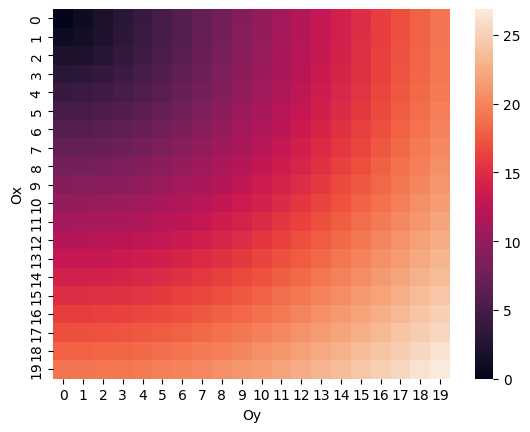

In [3]:
def dist(coord1, coord2):
    return np.sqrt(sum((c1 - c2) ** 2 for c1, c2 in zip(coord1, coord2)))


dist_map = {}
for i, sec in sec_map.items():
    for j, obs in obs_map.items():
        dist_map[i, j] = dist(sec, obs)
print(len(dist_map))
# print random 5 distances
for dist_idx in np.random.choice(np.arange(len(dist_map)), 5, replace=False):
    i, j = list(dist_map.keys())[dist_idx]
    print(sec_map[i], obs_map[j], dist_map[i, j])

# show the distance heatmap
fig, ax = plt.subplots()
sec_coord = (0, 0)
sec_idx = [i for i, coord in sec_map.items() if coord == sec_coord][0]
data = []
for obs_idx in obs_map:
    obs_coord = obs_map[obs_idx]
    data.append((obs_coord[0], obs_coord[1], dist_map[sec_idx, obs_idx]))
df = pd.DataFrame(data, columns=["Ox", "Oy", "distance"])
df = df.pivot("Ox", "Oy", "distance")
sns.heatmap(df, ax=ax)
plt.show()

(400, 400)
0.9999999999999998
sec_idx: 0


/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85296/3133872696.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  prob_o_given_s_df = prob_o_given_s_df.pivot("Ox", "Oy", "prob")


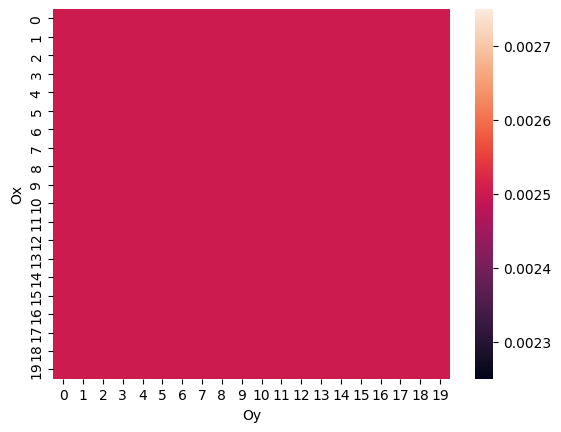

In [4]:
# Initial distribution
pso = np.ones((len(sec_map), len(obs_map))) / len(obs_map)
print(pso.shape)
print(np.sum(pso[0]))

# initial heatmap
fig, ax = plt.subplots()
sec_coord = (0, 0)
sec_idx = [i for i, coord in sec_map.items() if coord == sec_coord][0]
print(f"sec_idx: {sec_idx}")
prob_o_given_s = pso[sec_idx]
prob_o_given_s_data = []
for obs_idx in obs_map:
    prob_o_given_s_data.append(
        (obs_map[obs_idx][0], obs_map[obs_idx][1], prob_o_given_s[obs_idx])
    )
prob_o_given_s_df = pd.DataFrame(
    prob_o_given_s_data, columns=["Ox", "Oy", "prob"]
)
prob_o_given_s_df = prob_o_given_s_df.pivot("Ox", "Oy", "prob")
sns.heatmap(prob_o_given_s_df, ax=ax)
plt.show()

def entropy(p):
    return -np.sum(p * np.log2(p))

In [18]:
b = 0.5
iter_idx = 0
pso = np.ones((len(sec_map), len(obs_map))) / len(obs_map)
while True:
    # for _ in range(100):
    iter_idx += 1
    prev_pso = pso.copy()
    # Compute the marginal distribution of Y
    po = np.sum(pso, axis=0)
    po = po / np.sum(po)
    # DEBUG; draw po
    # fig, ax = plt.subplots()
    # prob_o_df = []
    # for obs_idx in obs_map:
    #     prob_o_df.append(
    #         (obs_map[obs_idx][0], obs_map[obs_idx][1], po[obs_idx])
    #     )
    # prob_o_df = pd.DataFrame(prob_o_df, columns=["Ox", "Oy", "prob"])
    # prob_o_df = prob_o_df.pivot("Ox", "Oy", "prob")
    # sns.heatmap(prob_o_df, ax=ax)
    # plt.show()
    # Compute the conditional distribution of X given Y
    for sec_idx, obs_idx in product(sec_map.keys(), obs_map.keys()):
        # print(sec_idx, obs_idx, np.exp(-b * dist_map[sec_idx, obs_idx]))
        pso[sec_idx, obs_idx] = (
            np.exp(-b * dist_map[sec_idx, obs_idx]) * po[obs_idx]
        )
        # DEBUG
        # if sec_map[sec_idx] == (0, 0) and obs_map[obs_idx] in [
        #     (0.0, 1.0),
        #     (0.0, 0.5),
        #     (0.0, 0.0),
        # ]:
        #     print(
        #         f"iter {iter_idx}: {sec_map[sec_idx]} {obs_map[obs_idx]} {dist_map[sec_idx, obs_idx]} {np.exp(-b * dist_map[sec_idx, obs_idx])} {po[obs_idx]} {pso[sec_idx, obs_idx]}",
        #         flush=True,
        #     )
    # normalize p(y|x)
    pso /= np.sum(pso, axis=1)[:, np.newaxis]
    assert np.isclose(np.sum(pso[0]), 1.0)
    if np.allclose(prev_pso, pso, atol=1e-3):
        break
    else:
        # print difference
        if iter_idx % 10 == 1:
            sum_diff = np.sum(np.abs(prev_pso - pso))
            pso_norm = pso / np.sum(pso)
            ps = np.sum(pso_norm, axis=1)
            po = np.sum(pso_norm, axis=0)
            pso_nz = pso_norm[pso_norm > 0].flatten()
            mi = entropy(po[po > 0]) + entropy(ps[ps > 0]) - entropy(pso_nz)
            print(
                f"iter {iter_idx}: sum_diff={sum_diff:.6f}, mi={mi:.6f}",
                flush=True,
            )
            # DEBUG
            # fig, ax = plt.subplots()
            # sec_coord = (0, 0)
            # sec_idx = list(sec_map.keys())[list(sec_map.values()).index(sec_coord)]
            # prob_o_given_s = pso[sec_idx]
            # o_coords_npy = np.array(list(obs_coords))
            # prob_o_given_s_df = pd.DataFrame(
            #     data={
            #         "Ox": o_coords_npy[:, 0],
            #         "Oy": o_coords_npy[:, 1],
            #         "prob": prob_o_given_s,
            #     }
            # )
            # prob_o_given_s_df = prob_o_given_s_df.pivot("Ox", "Oy", "prob")
            # sns.heatmap(prob_o_given_s_df, ax=ax)
            # plt.show()

iter 1: sum_diff=523.033536, mi=1.959598
iter 11: sum_diff=8.576029, mi=1.860979
iter 21: sum_diff=4.339777, mi=1.839640
iter 31: sum_diff=3.112526, mi=1.831219
iter 41: sum_diff=2.502444, mi=1.827109
iter 51: sum_diff=2.039725, mi=1.824773
iter 61: sum_diff=1.674603, mi=1.823333


mi: 1.8227295392302523


/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85296/4206684750.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  prob_o_df = prob_o_df.pivot("Ox", "Oy", "prob")


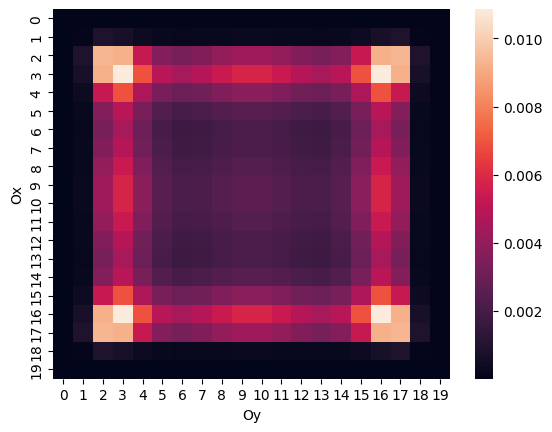

sec_idx: 189


/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_85296/4206684750.py:39: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  prob_o_given_s_df = prob_o_given_s_df.pivot("Ox", "Oy", "prob")


sec_idx: 84
sec_idx: 89
sec_idx: 0


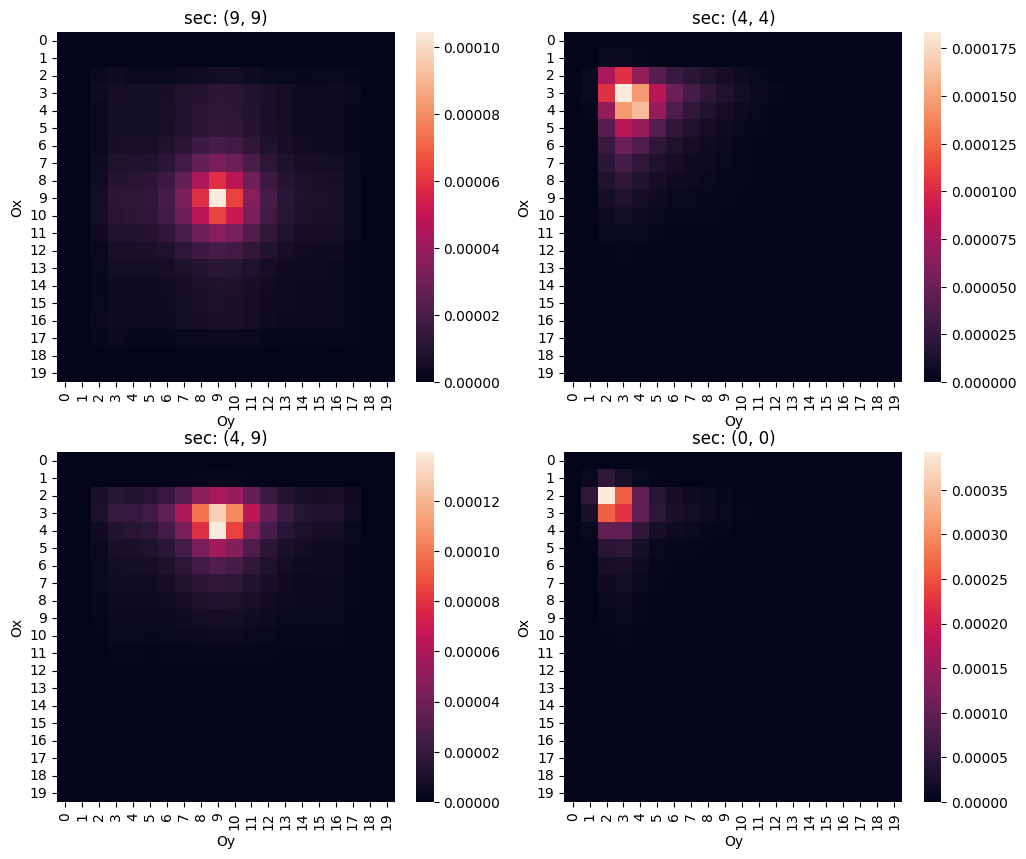

In [19]:
# print mutual information
pso = pso / np.sum(pso)
ps_nz = np.sum(pso, axis=1)
ps = np.sum(pso, axis=1)
ps = ps / np.sum(ps)
ps_nz = ps[ps > 0]
po = np.sum(pso, axis=0)
po = po / np.sum(po)
po_nz = po[po > 0]
mi = entropy(ps) + entropy(po) - entropy(pso.flatten())
print(f"mi: {mi}")

# draw heatmat of p(y)
fig, ax = plt.subplots()

prob_o_df = []
for obs_idx in obs_map:
    prob_o_df.append((obs_map[obs_idx][0], obs_map[obs_idx][1], po[obs_idx]))
prob_o_df = pd.DataFrame(prob_o_df, columns=["Ox", "Oy", "prob"])
prob_o_df = prob_o_df.pivot("Ox", "Oy", "prob")
sns.heatmap(prob_o_df, ax=ax)
plt.show()

# draw heatmap of p(o|s) for several sec
sec_coords = [(9, 9), (4, 4), (4, 9), (0, 0)]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for idx, sec_coord in enumerate(sec_coords):
    sec_idx = list(sec_map.keys())[list(sec_map.values()).index(sec_coord)]
    print(f"sec_idx: {sec_idx}")
    prob_o_given_s = pso[sec_idx]
    o_coords_npy = np.array(list(obs_coords))
    prob_o_given_s_df = pd.DataFrame(
        data={
            "Ox": o_coords_npy[:, 0],
            "Oy": o_coords_npy[:, 1],
            "prob": prob_o_given_s,
        }
    )
    prob_o_given_s_df = prob_o_given_s_df.pivot("Ox", "Oy", "prob")
    sns.heatmap(prob_o_given_s_df, ax=axes[idx // 2, idx % 2])
    axes[idx // 2, idx % 2].set_title(f"sec: {sec_coord}")
plt.show()